# Projet 3A : classification de battements cardiaques

## Nom du binôme : Tom Bertrand et Héloïse Lafargue

Cet ensemble de données a été créé à l'origine pour un défi d'apprentissage automatique visant à classer les bruits de battements cardiaques.

<img src="files/BattementCardiaque.PNG" width="600" height="300"  >

Les données ont été recueillies auprès de deux sources :
- (A) auprès du grand public via une application de smartphone,
- (B) dans le cadre d'un essai clinique dans des hôpitaux utilisant le stéthoscope numérique.


Les enregistrements de ces 2 sources étant de durées différentes, ils ont été ensuite transformés en MFCC pour extraire le contenu fréquentiel de ces données.


Ces 6 séances se décomposent en 4 parties :
- Partie I : Implémenter la DTW pour créer un système de reconnaissance;
- Partie II : Réduction de dimension par ACP et classification par kppv
- Partie III : Classification par Forêts aléatoires
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW pour créer un système de reconnaissance;
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
3. Réduction de dimension par ACP et classification par kppv
4. Classification par Forêts aléatoires
5. Classification par réseaux de neurones
5. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages)

In [48]:
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
import sklearn
import math
from scipy import stats
#import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Exemples de sons de l'ensemble A de battements cardiaques à classer (smartphone)



In [ ]:
# Son d'un battement normal
x0,sr0=librosa.load("/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/normalA.wav",duration=5)
ipd.Audio(x0,rate=sr0)


In [ ]:
# Son d'un murmure cardiaque

x1,sr1=librosa.load("/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/murmurA.wav",duration=5)
ipd.Audio(x1,rate=sr1)

In [ ]:
# Son d'un artefact
x3,sr3=librosa.load("/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/artifactA.wav",duration=5)
ipd.Audio(x3,rate=sr3)

## Exemples de sons de l'ensemble B de battements cardiaques à classer (stéthoscope numérique)



In [ ]:
# Son d'un battement normal - ensemble B
x4,sr4=librosa.load("/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/normalB.wav",duration=5)
ipd.Audio(x4,rate=sr4)


In [ ]:
# Son d'un murmure cardiaque - ensemble B

x5,sr5=librosa.load("/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/murmurB.wav",duration=5)
ipd.Audio(x5,rate=sr5)

## Chargement des données

A chaque enregistrement, 20 coefficients MFCC sont calculés en réalisant la moyenne sur chaque fenêtre de 10ms.

*DataMFCC.csv* regroupe tous les enregistrements des 2 dispositifs.

Le fichier source *DataMFCC.csv* sur lequel vous travaillez est la conversion des enregistrements audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

La matrice de données est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 20.

In [49]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/DataMFCC.csv')
#data = pd.read_csv('DataMFCC.csv')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,label
0,-489.62180,70.23919,61.142830,48.898050,36.555330,26.469486,19.623278,15.663741,13.472218,11.869776,...,8.004507,5.803412,3.905093,2.625853,2.056817,2.049077,2.306891,2.535396,2.566249,normal
1,-406.42853,153.23886,-1.369525,16.263828,10.937109,16.939487,4.494656,6.633343,6.228123,3.696192,...,-2.162616,-0.629793,-0.598225,-1.809965,-2.767086,-3.141027,-3.952870,-3.527147,-4.081270,normal
2,-511.58224,82.09152,6.478385,35.782322,4.926917,23.501286,2.172139,16.772097,-0.364136,12.615507,...,10.425499,-2.136471,6.526673,-2.714465,4.534374,-2.864164,2.395745,-2.710135,1.320221,normal
3,-514.13293,78.29218,65.463070,49.305313,34.505836,23.954039,18.073490,15.343872,13.722630,11.918728,...,7.061982,4.627193,2.702706,1.549387,1.235011,1.578198,2.168477,2.570371,2.564390,normal
4,-371.67172,155.28653,35.827470,19.501045,37.935867,34.704395,17.897236,9.181622,10.555704,10.437612,...,-0.750443,2.518559,6.119143,1.359976,-3.627311,-3.266012,0.071095,0.160198,-1.439477,normal


In [50]:
data["label"].value_counts()

normal      351
murmur      129
artifact     40
Name: label, dtype: int64

In [51]:
X=data.iloc[:,0:20]
X.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,-489.62180,70.23919,61.142830,48.898050,36.555330,26.469486,19.623278,15.663741,13.472218,11.869776,10.107503,8.004507,5.803412,3.905093,2.625853,2.056817,2.049077,2.306891,2.535396,2.566249
1,-406.42853,153.23886,-1.369525,16.263828,10.937109,16.939487,4.494656,6.633343,6.228123,3.696192,-3.058978,-2.162616,-0.629793,-0.598225,-1.809965,-2.767086,-3.141027,-3.952870,-3.527147,-4.081270
2,-511.58224,82.09152,6.478385,35.782322,4.926917,23.501286,2.172139,16.772097,-0.364136,12.615507,-1.403247,10.425499,-2.136471,6.526673,-2.714465,4.534374,-2.864164,2.395745,-2.710135,1.320221
3,-514.13293,78.29218,65.463070,49.305313,34.505836,23.954039,18.073490,15.343872,13.722630,11.918728,9.623236,7.061982,4.627193,2.702706,1.549387,1.235011,1.578198,2.168477,2.570371,2.564390
4,-371.67172,155.28653,35.827470,19.501045,37.935867,34.704395,17.897236,9.181622,10.555704,10.437612,2.700969,-0.750443,2.518559,6.119143,1.359976,-3.627311,-3.266012,0.071095,0.160198,-1.439477


In [52]:
from sklearn.preprocessing import LabelEncoder

# Encode le label de chaque classe par un chiffre
ylabel=data["label"]
le=LabelEncoder().fit(ylabel)
y=le.transform(ylabel)

print('Label',ylabel[40],'correspond au numero',y[40])
print('Label',ylabel[0],'correspond au numero',y[0])
print('Label',ylabel[100],'correspond au numero',y[100])


Label artifact correspond au numero 0
Label normal correspond au numero 2
Label murmur correspond au numero 1


In [53]:
# création de la base d'apprentissage et de test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=31,stratify=y) # stratify pour garder les mêmes proportions qu'au départ

print("Base d'apprentissage - X_Train: ",len(X_train),"\n","Base de test - X_Test: ",len(X_test),sep="")

Base d'apprentissage - X_Train: 390
Base de test - X_Test: 130


In [54]:
# Description de l'ensemble d'apprentissage
values,count=np.unique(y_train, return_counts=True)

print('label:',values,'nbre de valeurs:',count )

label: [0 1 2] nbre de valeurs: [ 30  97 263]


In [55]:
# Conversion en matrice des bases d'apprentissage et test
X_train = np.array(X_train)
X_test = np.array(X_test)

# Liste des données par classe
liste_classe0 = np.ravel(np.where(y_train==0))
liste_classe1 = np.ravel(np.where(y_train==1))
liste_classe2 = np.ravel(np.where(y_train==2))

### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [56]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

# Partie I-a : Implémentation de l'algorithme de programmation dynamique

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.


In [ ]:
def distance(i,j):
    return abs(i- j)

In [ ]:
df_set_A = pd.read_csv('/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/DataMFCC_setA.csv')
df_set_B = pd.read_csv('/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/DataMFCC_setB.csv')

set_A = np.array(df_set_A.drop(columns=['label']))
set_B = np.array(df_set_B.drop(columns=['label']))

N = np.size(set_A, 1)
NN = np.size(set_A, 0)
M = np.size(set_B, 1)
MM = np.size(set_B, 0)

print(set_A.shape)

dataA=set_A[0,:]
dataB=set_B[1,:]

print(dataA.shape)

(105, 20)
(20,)


In [ ]:
def scoreDTW(dataA, dataB):
    g = np.zeros((N+1, M+1))

    w0, w1, w2 = 1, 2, 1

    for j in range(1, M+1):
        g[0, j] = 10**8
    for i in range(1, N+1):
        g[i, 0] = 10**8

    for i in range(1, N+1):
        for j in range(1, M+1):
            d = distance(dataA[i-1], dataB[j-1])
            c0 = g[i-1, j] + w0 * d
            c1 = g[i-1, j-1] + w1 * d
            c2 = g[i, j-1] + w2 * d
            # Recherche du chemin optimal
            g[i, j] = min(c0, c1, c2)

    # Chemin optimal
    path = []
    i, j = N, M
    while i > 0 or j > 0:
        path.append((i-1, j-1))  # Ajouter l'index actuel au chemin optimal
        if i > 0 and j > 0:
            prev_min = min(g[i-1, j], g[i-1, j-1], g[i, j-1])
            if prev_min == g[i-1, j-1]:
                i, j = i-1, j-1
            elif prev_min == g[i-1, j]:
                i -= 1
            else:
                j -= 1
        elif i > 0:
            i -= 1
        else:
            j -= 1

    path.reverse()  # Inverser le chemin pour obtenir l'ordre croissant

    S = g[N, M] / (N+M)
    return S, path

In [ ]:
# Score correspond à la médiane des scores comparés à 10 éléments "connus"

def score_mediane(label, elem_test, dataset='A'):
    if dataset == 'A':
        data_set = set_A
        df_set = df_set_A
    elif dataset == 'B':
        data_set = set_B
        df_set = df_set_B
    else:
        raise ValueError("Dataset non reconnu. Utilisez 'A' ou 'B'.")

    if label == "normal":
        i0 = np.where(df_set['label'].values == "normal")[0][0]
    elif label == "murmur":
        i0 = np.where(df_set['label'].values == "murmur")[0][0]
    elif label == "artifact":
        i0 = np.where(df_set['label'].values == "artifact")[0][0]

    l_scores = []
    l_path = []
    for j in range(10):
        score, optimal_path = scoreDTW(data_set[j + i0, :], elem_test)
        l_scores.append(score)
        l_path.append(optimal_path)

    sorted_scores = sorted(l_scores)
    score = sorted_scores[4]  # Médiane des scores
    ind = l_scores.index(score)
    optimal_path = l_path[ind]
    return score, optimal_path

In [ ]:
# Calcul du bon label avec le score minimal

def predicted_label(elem_test, mode='A'):
    # Label artifact correspond au numéro 0
    # Label murmur correspond au numéro 1
    # Label normal correspond au numéro 2
    final_scores_labels = []
    final_paths = []

    if mode == 'A':
        labels = ["artifact", "murmur", "normal"]
    elif mode == 'B':
        labels = ["murmur", "normal"]
    else:
        raise ValueError("Mode non reconnu. Utilisez 'A' ou 'B'.")

    for label in labels:
        score, optimal_path = score_mediane(label, elem_test, dataset=mode)
        final_scores_labels.append(score)
        final_paths.append(optimal_path)

    best_score = min(final_scores_labels)
    best_label = final_scores_labels.index(best_score)
    best_path = final_paths[best_label]

    return best_score, best_label, best_path

# Partie I-b : Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [ ]:
# Ex pour set_A avec artifact
score_A, path_A = score_mediane("artifact", dataB, dataset='A')
print("Pour set_A avec artifact :")
print("Score DTW entre dataA et dataB :", score_A)
print("Chemin optimal :", path_A)

# Ex pour set_A avec murmur
score_A, path_A = score_mediane("murmur", dataB, dataset='A')
print("Pour set_A avec murmur :")
print("Score DTW entre dataA et dataB :", score_A)
print("Chemin optimal :", path_A)

# Ex pour set_B avec murmur
score_B, path_B = score_mediane("murmur", dataB, dataset='B')
print("\nPour set_B:")
print("Score DTW entre dataB et dataB avec murmur :", score_B)
print("Chemin optimal :", path_B)

Pour set_A avec artifact :
Score DTW entre dataA et dataB : 16.75758755200001
Chemin optimal : [(0, 0), (1, 1), (1, 2), (2, 3), (2, 4), (3, 5), (3, 6), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (10, 8), (11, 9), (11, 10), (12, 11), (13, 11), (14, 12), (15, 13), (16, 13), (17, 14), (17, 15), (17, 16), (18, 17), (19, 18), (19, 19)]
Pour set_A avec murmur :
Score DTW entre dataA et dataB : 16.2114240145
Chemin optimal : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 6), (8, 6), (9, 7), (10, 8), (11, 9), (12, 10), (13, 11), (13, 12), (14, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19)]

Pour set_B:
Score DTW entre dataB et dataB avec murmur : 6.5197524635
Chemin optimal : [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19)]


In [ ]:
# Prédiction et précision classes du set_A
labels_refA = df_set_A['label']
labels_predA = []
matching_labels = []
for i in range(NN):
  best_score, best_label, best_path = predicted_label(set_A[i,:])
  match best_label:
    case 0 :
      labels_predA.append("artifact")
    case 1 :
      labels_predA.append("murmur")
    case 2 :
      labels_predA.append("normal")
  matching_labels.append(labels_refA[i] == labels_predA[i])

accuracyDTWA = sum(matching_labels) / len(matching_labels)
print("Accuracy:", accuracyDTWA)


Accuracy: 0.6190476190476191


In [ ]:
# Prédiction et précision classes du set_B
labels_refB = df_set_B['label']
labels_predB = []
matching_labels = []
for i in range(MM):
  best_score, best_label, best_path = predicted_label(set_B[i,:], mode='B')
  match best_label:
    case 0 :
      labels_predB.append("murmur")
    case 1 :
      labels_predB.append("normal")
  matching_labels.append(labels_refB[i] == labels_predB[i])

accuracyDTWB = sum(matching_labels) / len(matching_labels)
print("Accuracy for set_B:", accuracyDTWB)

Accuracy for set_B: 0.7469879518072289


## **Evaluation :**
A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

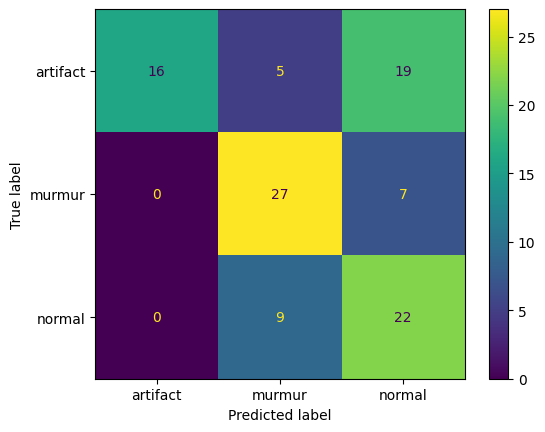

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labelsA = ["artifact","murmur","normal"]
mat_conf = confusion_matrix(labels_refA, labels_predA)
dispDTWA = ConfusionMatrixDisplay(confusion_matrix=mat_conf, display_labels= labelsA)
dispDTWA.plot()
plt.show()

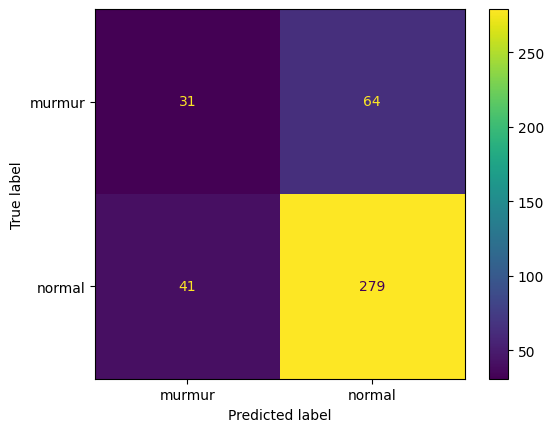

In [ ]:
labelsB = ["murmur","normal"]
mat_conf = confusion_matrix(labels_refB, labels_predB)
dispDTWB = ConfusionMatrixDisplay(confusion_matrix=mat_conf, display_labels= labelsB)
dispDTWB.plot()
plt.show()

# Partie II : comparaison de la programmation dynamique avec une méthode de classification après réduction de dimension par ACP

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.


In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### Prétraitement par ACP

Pour tester une autre méthode de classification,

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les $p$ axes principaux de l'ACP en
extrayant les $p$ vecteurs propres, notés $X_1$, $X_2$,.., $X_p$, associés aux $p$ plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$. Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2...X_p]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les $p$ vecteurs propres, notés $X_1$, $X_2$,.. $X_p$, associés aux $p$ plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2..X_p]$.


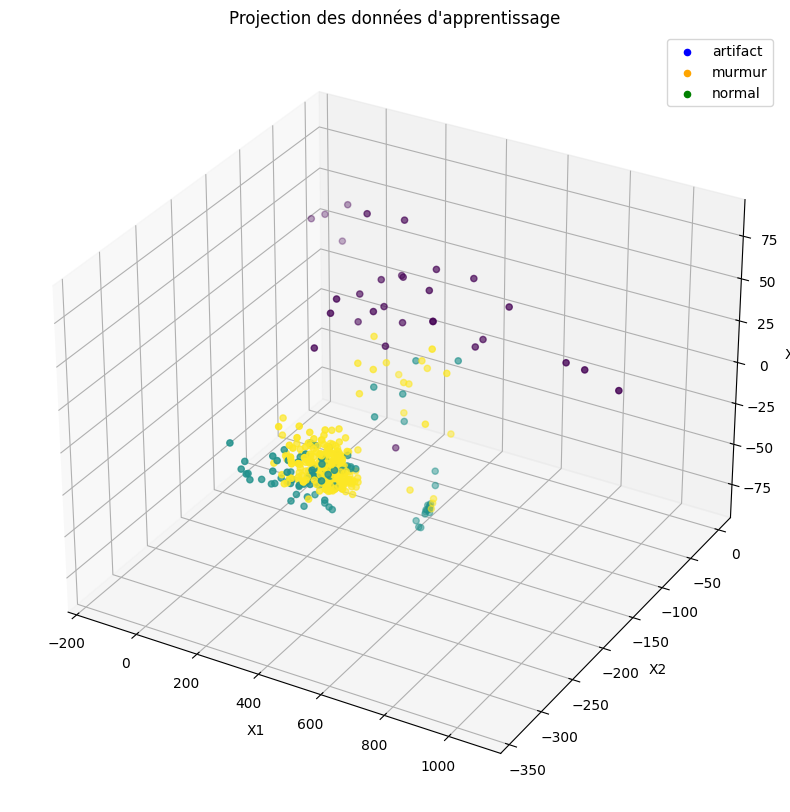

In [ ]:
# Calcul de l'ACP
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Calcul des valeurs propres
eigval = pca.explained_variance_

# Calcul des vecteurs propres
eigvec = pca.components_

# Projection des données
X_train_proj = X_train.dot(eigvec.T)
X_test_proj = X_test.dot(eigvec.T)

# Affichage des données projetées
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_proj[:, 0], X_train_proj[:, 1], X_train_proj[:, 2], c=y_train)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.scatter([], [], [], c='blue', label='artifact')
ax.scatter([], [], [], c='orange', label='murmur')
ax.scatter([], [], [], c='green', label='normal')
ax.legend()
plt.title("Projection des données d'apprentissage")
plt.show()

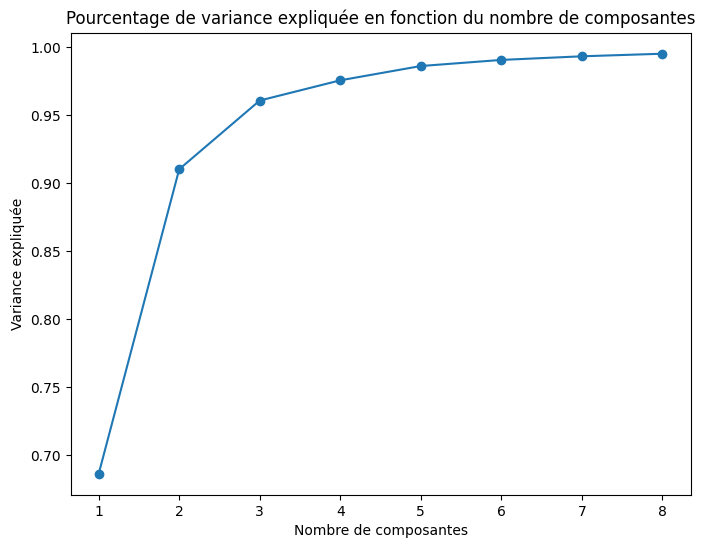

In [ ]:
def compare_p_values_with_elbow(X_train, X_test, p_values):
    results = {}
    variances_explained = []

    for p in p_values:
        # Calcul de la matrice de covariance ΣApp
        cov_matrix = np.cov(X_train, rowvar=False)

        # Calcul des valeurs propres et vecteurs propres
        eigenvalues, _ = np.linalg.eig(cov_matrix)

        # Ajout de la variance expliquée pour ce nombre de composantes
        total_variance = sum(eigenvalues)
        variance_explained = sum(eigenvalues[:p]) / total_variance
        variances_explained.append(variance_explained)

    # Affichage du graphique du pourcentage de variance expliquée
    plt.figure(figsize=(8, 6))
    plt.plot(p_values, variances_explained, marker='o')
    plt.xlabel('Nombre de composantes')
    plt.ylabel('Variance expliquée')
    plt.title('Pourcentage de variance expliquée en fonction du nombre de composantes')
    plt.show()

# Utilisation de la fonction avec p de 1 à 5 pour générer le graphique
p_values_to_test = [1, 2, 3, 4, 5, 6, 7, 8]
compare_p_values_with_elbow(X_train, X_test, p_values_to_test)


Il semble que cela fonctionne très bien pour p = 3.

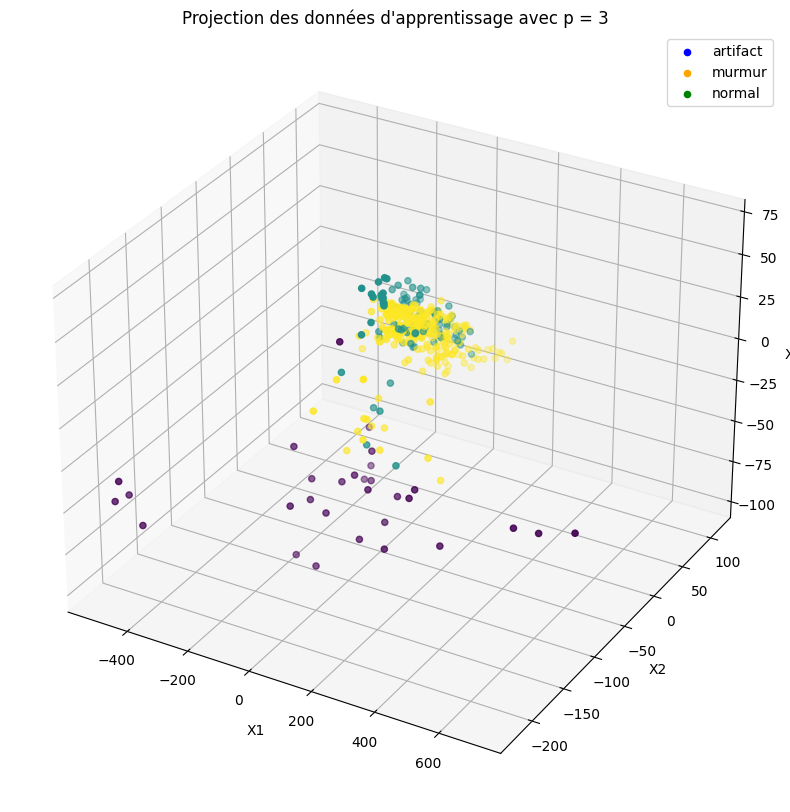

In [ ]:
best_p = 3

# Calcul de la matrice de covariance ΣApp
cov_matrix = np.cov(X_train_pca, rowvar=False)

# Calcul des valeurs propres et vecteurs propres
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sélection des p plus grandes valeurs propres et vecteurs propres associés
sorted_indices = np.argsort(eigenvalues)[::-1]
top_p_indices = sorted_indices[:best_p]

top_p_eigenvalues = eigenvalues[top_p_indices]
top_p_eigenvectors = eigenvectors[:, top_p_indices]

# Nouveau repère P
new_basis_P = top_p_eigenvectors

# Projection des données d'apprentissage et de test dans le nouvel espace
X_train_proj_best_p = np.dot(X_train_pca, new_basis_P)
X_test_proj_best_p = np.dot(X_test_pca, new_basis_P)

# Afficher les données projetées pour l'apprentissage
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_proj_best_p[:, 0], X_train_proj_best_p[:, 1], X_train_proj_best_p[:, 2], c=y_train)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.scatter([], [], [], c='blue', label='artifact')
ax.scatter([], [], [], c='orange', label='murmur')
ax.scatter([], [], [], c='green', label='normal')
ax.legend()
plt.title(f"Projection des données d'apprentissage avec p = {best_p}")
plt.show()

### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir.


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.

Matrice de confusion :
[[10  0  0]
 [ 0 21 11]
 [ 3 15 70]]
Accuracy : 0.7769230769230769


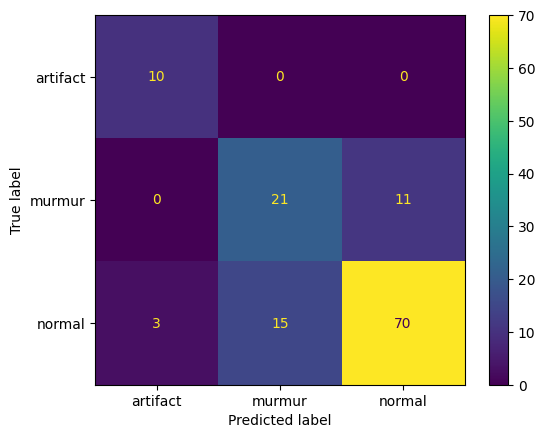

In [ ]:
# Classification par k-ppv
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = knn.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = knn.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

Matrice de confusion :
[[10  0  0]
 [ 0 24  8]
 [ 5 23 60]]
Accuracy : 0.7230769230769231


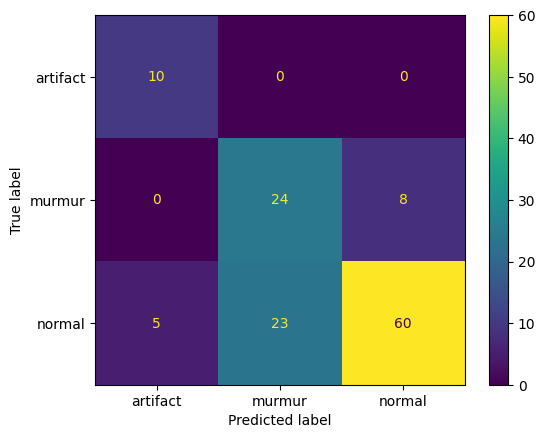

In [ ]:
# Classification par k-ppv
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = knn.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = knn.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

Matrice de confusion :
[[10  0  0]
 [ 0 17 15]
 [ 4  5 79]]
Accuracy : 0.8153846153846154


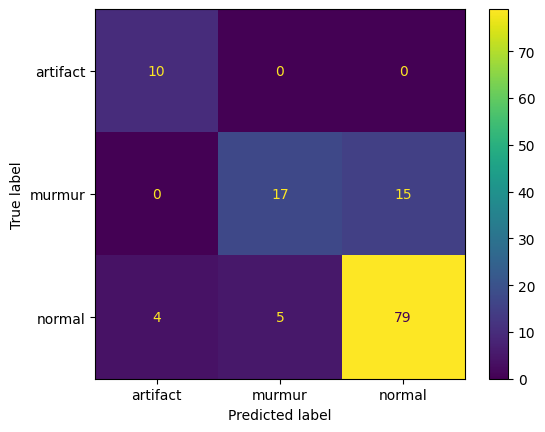

In [ ]:
# Classification par k-ppv
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = knn.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = knn.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

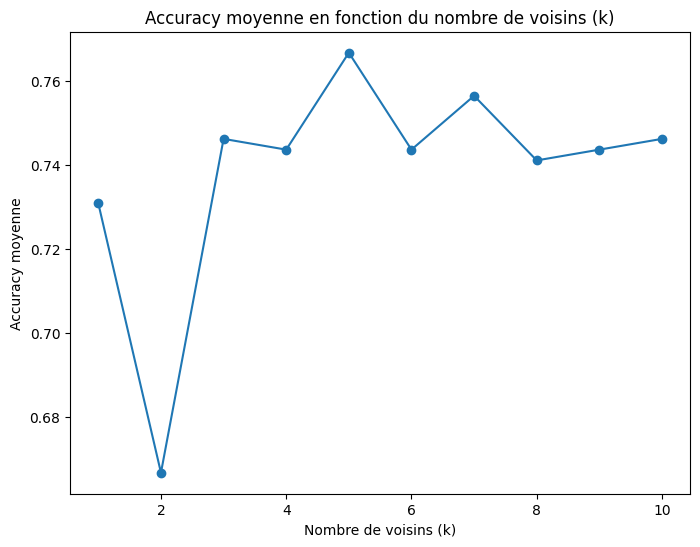

Meilleur k : 5 avec une accuracy moyenne de 0.77
Accuracy sur l'ensemble de test avec le meilleur k : 0.78


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def find_best_k(X_train, y_train, X_test, y_test, max_k=10):
    accuracies = []
    k_values = list(range(1, max_k + 1))

    for k in k_values:
        # Création du classificateur k-ppv avec k voisins
        knn = KNeighborsClassifier(n_neighbors=k)

        # Validation croisée avec 5 folds
        cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

        # Moyenne des scores de validation croisée
        avg_accuracy = np.mean(cv_scores)
        accuracies.append(avg_accuracy)

    # Affichage de la courbe d'accuracy en fonction de k
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, accuracies, marker='o')
    plt.xlabel('Nombre de voisins (k)')
    plt.ylabel('Accuracy moyenne')
    plt.title('Accuracy moyenne en fonction du nombre de voisins (k)')
    plt.show()

    # Trouver la meilleure valeur de k avec la meilleure accuracy
    best_k = k_values[np.argmax(accuracies)]
    print(f"Meilleur k : {best_k} avec une accuracy moyenne de {max(accuracies):.2f}")

    # Entrainement du modèle avec le meilleur k sur l'ensemble de test
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train, y_train)

    # Calcul de l'accuracy sur l'ensemble de test
    test_accuracy = best_knn.score(X_test, y_test)
    print(f"Accuracy sur l'ensemble de test avec le meilleur k : {test_accuracy:.2f}")

    return best_k

# Utilisation de la fonction avec les données projetées X_train_proj_best_p et X_test_proj_best_p pour best_p = 3
best_k = find_best_k(X_train_pca, y_train, X_test_pca, y_test, max_k=10)


Matrice de confusion :
[[10  0  0]
 [ 0 16 16]
 [ 4  8 76]]
Accuracy : 0.7846153846153846


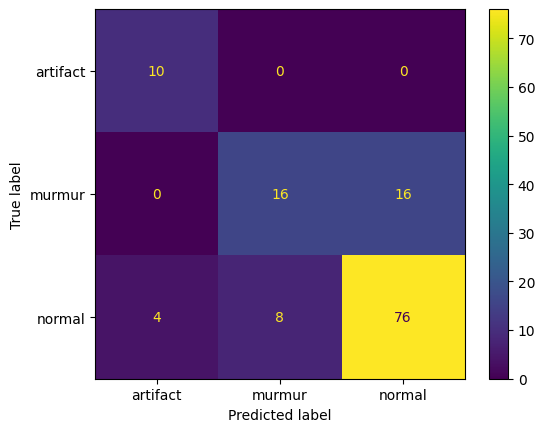

In [ ]:
# Classification par k-ppv
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = knn.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = knn.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

Accuracy DTW set_A :  0.6190476190476191


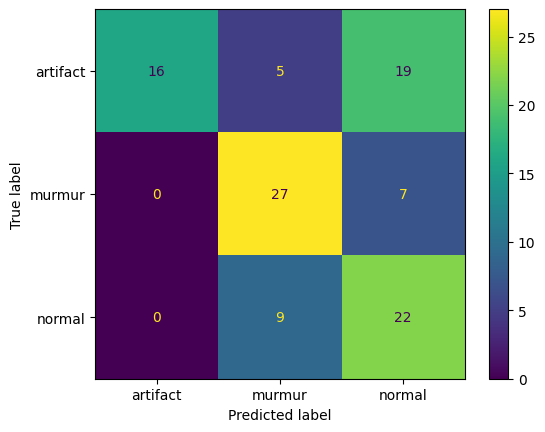

In [ ]:
print("Accuracy DTW set_A : ", accuracyDTWA)
dispDTWA.plot()
plt.show()

##Comparaison DTW / kppv
On remarque que la DTW a plus de problème à distinguer les artefacts des autres classes mais a de bons résultats sur les murmurs et battements normaux. De son côté, kppv a une meilleure précision globale et particulièrement sur les artefacts et battements normaux mais a de moins bons résultats avec les murmurs.

# Partie III : Classification par Forêts aléatoires

Les forêts aléatoires font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Matrice de confusion :
[[ 8  0  2]
 [ 0 13 19]
 [ 2  1 85]]
Accuracy : 0.8153846153846154


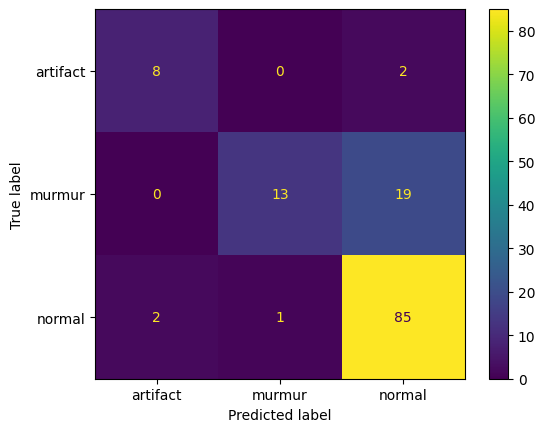

In [ ]:
# Modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = rf.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = rf.score(X_test_pca, y_test)
print("Accuracy :", accuracy)


Meilleurs paramètres: {'max_depth': 7, 'n_estimators': 300}
Matrice de confusion :
[[ 9  0  1]
 [ 0 13 19]
 [ 3  1 84]]
Accuracy : 0.8153846153846154


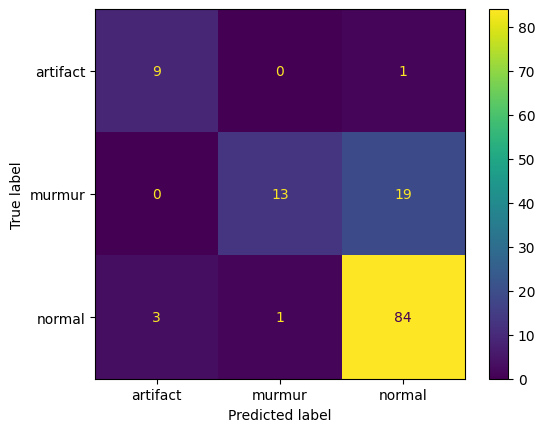

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(random_state=0)

# Définition de la grille de recherche pour GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9]
}

# Utilisation de GridSearchCV pour trouver les meilleurs hyperparamètres
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
cv_rf.fit(X_train_pca, y_train)

# Meilleurs paramètres et modèle
print("Meilleurs paramètres:", cv_rf.best_params_)
best_rf = cv_rf.best_estimator_

# Prédiction sur la base de test avec le meilleur modèle
y_pred = best_rf.predict(X_test_pca)

# Calcul de la matrice de confusion et affichage
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = best_rf.score(X_test_pca, y_test)
print("Accuracy :", accuracy)


# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différentes solveurs

In [ ]:
from sklearn.neural_network import MLPClassifier

Matrice de confusion :
[[ 7  1  2]
 [ 0 18 14]
 [ 1 12 75]]
Accuracy : 0.7692307692307693


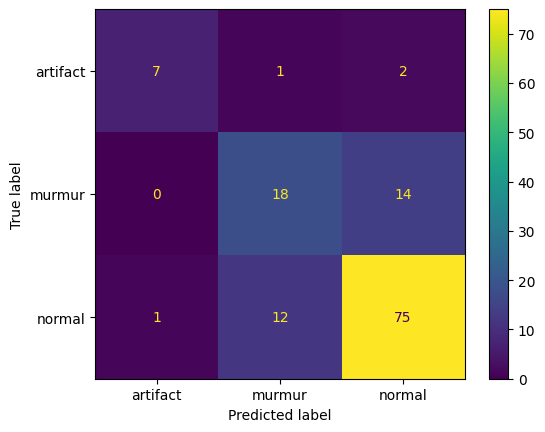

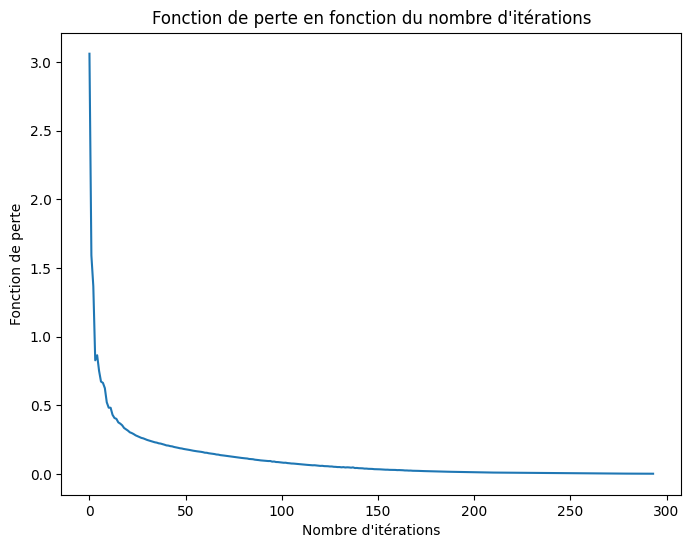

In [ ]:
# Avec MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
mlp.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = mlp.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = mlp.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

# Fonction de perte
loss_values = mlp.loss_curve_
plt.figure(figsize=(8, 6))
plt.plot(loss_values)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Fonction de perte')
plt.title('Fonction de perte en fonction du nombre d\'itérations')
plt.show()

Matrice de confusion :
[[ 6  0  4]
 [ 0 18 14]
 [ 2 11 75]]
Accuracy : 0.7615384615384615


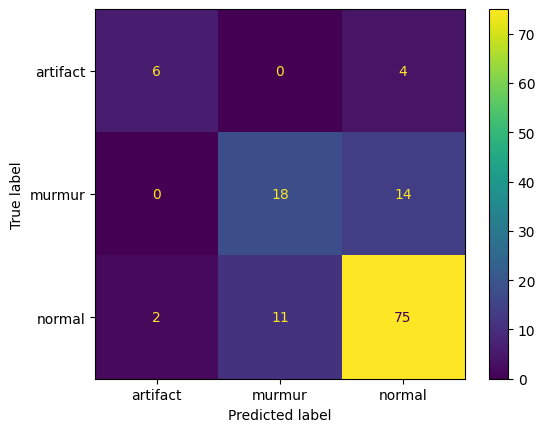

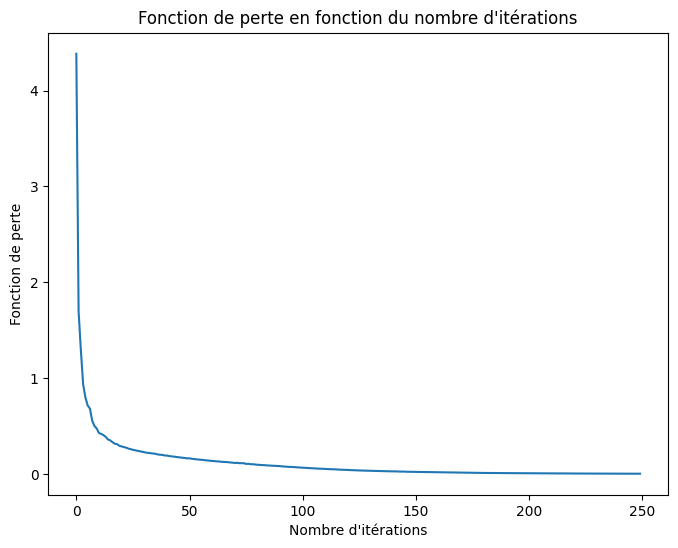

In [ ]:
# Avec une autre architecture et un autre solveur
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, solver='adam')
mlp.fit(X_train_pca, y_train)

# Prédiction sur la base de test
y_pred = mlp.predict(X_test_pca)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = mlp.score(X_test_pca, y_test)
print("Accuracy :", accuracy)

# Fonction de perte
loss_values = mlp.loss_curve_
plt.figure(figsize=(8, 6))
plt.plot(loss_values)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Fonction de perte')
plt.title('Fonction de perte en fonction du nombre d\'itérations')
plt.show()

# Partie V :Votre étude

Réaliser votre propre étude comparative entre les différents battements cardiaques.
- jouer sur les bases d'apprentissage/test, équilibre des classes
- les paramètres inhérents aux méthodes
- l'utilisation de prétraitement ou non
- utiliser les méthodes non supervisées...

Vous pouvez aussi réaliser une étude comparative entre les jeux de données A (*DataMFCC_SetA.csv*) et B (*DataMFCC_SetB.csv*)


### Récupérer les MFCC des fichiers audio

In [ ]:
import librosa
import numpy as np
import pandas as pd

def extract_mfcc(file_paths, label, n_mfcc=20):
    features = []

    for file in file_paths:
        try:
            # Charger le fichier audio
            signal, sample_rate = librosa.load(file, sr=None)

            # Calculer les MFCC
            mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

            # Moyenniser les coefficients MFCC
            mfccs_mean = np.mean(mfccs, axis=1)

            # Ajouter le label et les caractéristiques au tableau
            features.append(np.append(mfccs_mean, label))
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {file}: {e}")
            features.append(np.append([np.nan] * n_mfcc, label))  # Ajoute des valeurs NaN en cas d'erreur

    return features



In [ ]:
import os

# Chemins des dossiers
folder_paths = {
    'artifact': '/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/Set_A_artifact',
    'murmur': '/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/Set_A_murmur',
    'normal': '/content/drive/MyDrive/N7_Multimedia/Data_analysis/Projet_BattementCardiaque_N7/Set_A_normal'
}

all_features = []

# Traitement pour chaque dossier
for label, path in folder_paths.items():
    # Liste de tous les fichiers audio dans le dossier
    audio_files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.wav')]

    # Extraction des MFCC
    features = extract_mfcc(audio_files, label)
    all_features.extend(features)

# Créer un DataFrame et enregistrer en CSV
df = pd.DataFrame(all_features, columns=[f'mfcc{i}' for i in range(20)] + ['Label'])
df.to_csv('DataMFCC_our_A.csv', index=False)

In [ ]:
df

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,Label
0,-401.90738,164.81062,-58.317463,13.229384,10.860508,-15.933287,0.019981148,-13.644519,8.609695,-10.251033,...,-10.8193865,-13.534179,-11.827317,-3.8327477,-1.284082,-4.098318,-9.13165,-0.07470109,-4.0142293,artifact
1,54.625393,70.46708,-39.60718,13.036337,-4.0314426,-1.281671,-3.7978125,-2.390303,-3.181632,-2.4164717,...,-1.9486262,-1.3403102,-0.445149,-1.3206037,-0.23129234,-0.19199274,0.41576678,-1.6389968,-1.7073883,artifact
2,-351.49493,150.23912,67.18877,15.069814,-4.9765363,-6.7459207,-8.908663,-19.443176,-30.434978,-33.34833,...,-18.187145,-16.021505,-18.02899,-19.35677,-17.578962,-14.562918,-11.977705,-8.320749,-2.302865,artifact
3,-425.01157,101.98345,6.312329,4.4396434,3.0431933,0.013993725,-0.84163797,-4.9222536,-0.98869455,-5.074303,...,-6.8269143,-3.408157,-6.0622544,-2.9192822,-5.0433974,-2.3123517,-4.572983,-2.42044,-4.426513,artifact
4,-486.64224,93.6632,-25.499802,12.071202,-4.054235,-4.1628966,-0.19914462,-12.180669,-1.0561742,-11.110253,...,-7.1830072,2.0144417,-7.0922737,1.0326906,-4.3552685,0.7392053,-5.504707,-1.2949178,-5.20937,artifact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-532.7327,41.8584,19.42001,13.994753,13.489591,10.861273,9.23302,10.960892,8.65145,2.3836637,...,-0.47388667,-0.6919052,-0.31374368,0.49287397,-0.9217793,-2.749417,-4.079781,-3.5684144,-3.6402516,normal
101,-576.4376,96.39936,28.279396,3.3105412,8.912554,6.452471,8.368432,5.7060385,3.1585119,-1.2518138,...,-2.8890674,-0.7147973,-1.8413792,-0.86030227,-2.961211,-1.5593976,-3.27879,-1.9508821,-3.3353627,normal
102,-459.18704,116.94609,13.236116,27.06791,12.2739525,15.927383,11.042683,12.33995,16.44631,12.332628,...,9.919655,9.943404,6.7811046,4.4433684,4.556873,2.5409005,4.1454716,3.6600945,3.8791988,normal
103,-596.28906,120.040535,28.13429,28.43375,34.78845,7.191467,24.777647,-1.2345338,15.882701,-1.6929157,...,-1.7958957,2.0674498,-0.99411553,-1.4173614,-1.2334136,-3.2238798,-2.0361598,-3.103184,-2.78883,normal


###Pré-traitement

Pour le pré-traitement nous avons :
- observé la distribution des variables pour savoir si une normalisation serait pertinente (mfcc0 et mcff1 trop différentes du reste -> normaliser),
- effectué une normalisation sur le dataset,
- analysé la répartition des données par classe ("normal" bien représenté, le reste non -> ok "normal", possibilité d'écarter "artifact"),
- séparer les données en 75% entraînement et 25% test.

#### Observations des données

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mfcc0   520 non-null    float64
 1   mfcc1   520 non-null    float64
 2   mfcc2   520 non-null    float64
 3   mfcc3   520 non-null    float64
 4   mfcc4   520 non-null    float64
 5   mfcc5   520 non-null    float64
 6   mfcc6   520 non-null    float64
 7   mfcc7   520 non-null    float64
 8   mfcc8   520 non-null    float64
 9   mfcc9   520 non-null    float64
 10  mfcc10  520 non-null    float64
 11  mfcc11  520 non-null    float64
 12  mfcc12  520 non-null    float64
 13  mfcc13  520 non-null    float64
 14  mfcc14  520 non-null    float64
 15  mfcc15  520 non-null    float64
 16  mfcc16  520 non-null    float64
 17  mfcc17  520 non-null    float64
 18  mfcc18  520 non-null    float64
 19  mfcc19  520 non-null    float64
 20  label   520 non-null    object 
dtypes: float64(20), object(1)
memory usage:

Le jeu de données a 20 variables (les 20 premières mfcc) avec 3 classes : "artifact", "murmur", "normal". Il y a 520 observations pour chaque attribut.

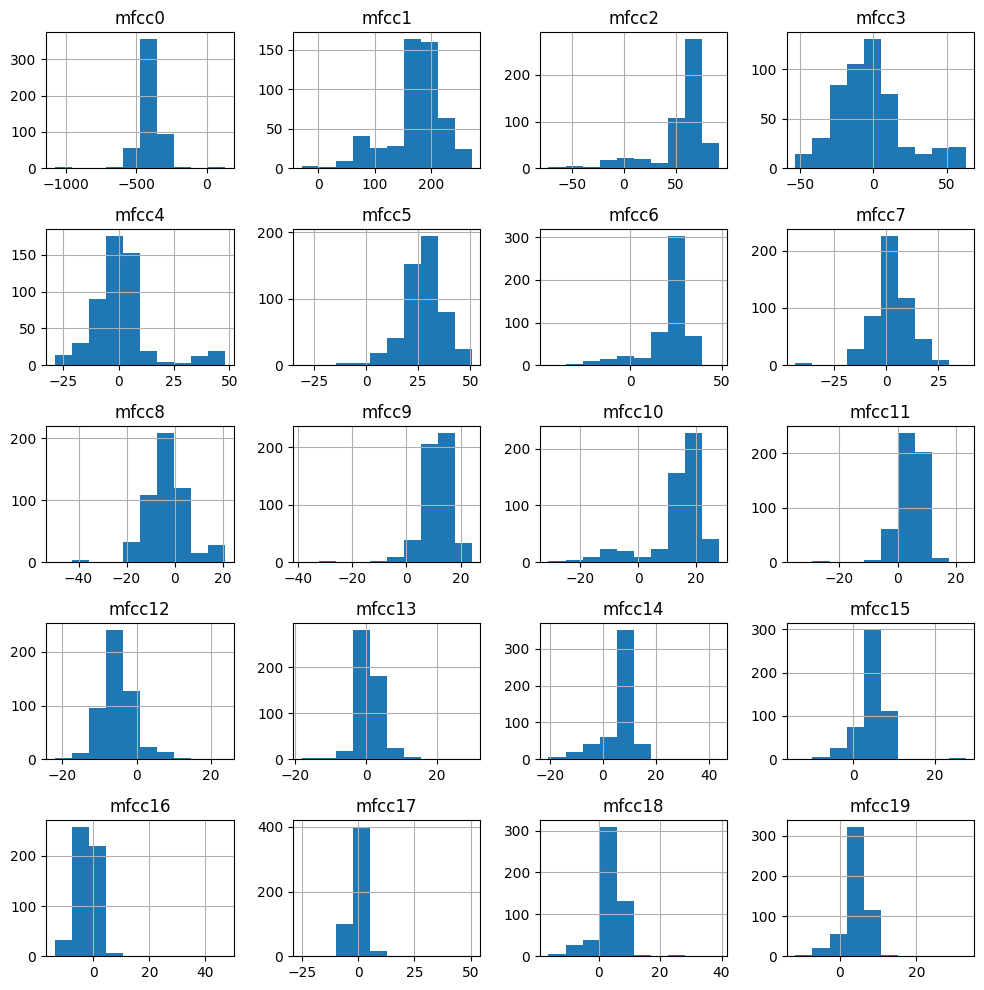

In [58]:
data.hist(figsize=(10, 10))
plt.tight_layout()

La répartition des variables est assez distinctes surtout entre les 2 premières mfcc et le reste. Il semble donc utile de normaliser le dataset.

Cette observation est confortée en regardant les moyennes des varibles (ci-dessous) : il y en a beaucoup autour de valeurs faibles (entre -5 et 5, quelques unes à 10-27) et puis les deux premières à -402 et 171.

In [59]:
data.describe()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,-402.936275,171.576008,54.696070,-2.490263,1.034554,27.069048,20.499840,2.344616,-3.362874,10.765391,13.440328,4.294267,-5.020916,0.656121,6.098579,4.394441,-2.171637,-0.628516,3.752791,4.336873
std,95.348240,49.182907,26.470911,23.154230,13.205461,9.936994,12.649183,9.353119,8.605052,6.391949,10.060241,4.844960,4.700289,3.497655,6.219069,3.623359,4.347335,3.966403,4.650259,3.291353
min,-1081.043300,-29.527248,-72.262596,-53.103825,-28.883732,-31.063078,-44.440163,-43.664690,-49.969433,-38.816525,-31.041983,-35.024475,-22.014156,-18.243840,-20.437279,-14.023951,-13.795611,-25.276120,-16.287870,-11.521476
25%,-443.332795,156.084563,53.144026,-18.204156,-5.908226,22.754944,19.595766,-2.281318,-8.101302,8.345498,13.185109,2.331068,-7.803521,-1.292404,5.522547,3.131205,-4.374352,-2.194062,2.778889,3.259631
50%,-401.399705,179.759370,62.886970,-4.510548,-0.281301,27.711409,23.939137,2.380496,-3.116332,11.558715,16.232914,5.098576,-5.167056,0.433560,7.680224,5.128785,-2.021406,-0.969859,4.692037,5.034844
75%,-362.938595,201.546010,69.022215,7.492512,5.206328,33.201371,27.568269,7.430792,0.995943,14.118540,18.865811,7.095817,-2.839748,1.946821,9.577372,6.445357,-0.102620,0.291298,5.921865,6.168637
max,130.121480,271.676330,91.316150,62.930397,48.075516,50.836890,48.271700,38.122517,20.969564,24.214865,27.890100,23.331343,23.732828,29.896132,43.768090,27.439344,47.039963,50.584553,39.139015,32.866734


#### Normalisation

In [60]:
from sklearn.preprocessing import StandardScaler

# Séparer les caractéristiques et les labels
features = data.drop('label', axis=1)
labels = data['label']

# Initialiser le StandardScaler
scaler = StandardScaler()

# Normaliser les caractéristiques
normalized_features = scaler.fit_transform(features)

# Recombiner les caractéristiques normalisées avec les labels
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df['label'] = labels.values


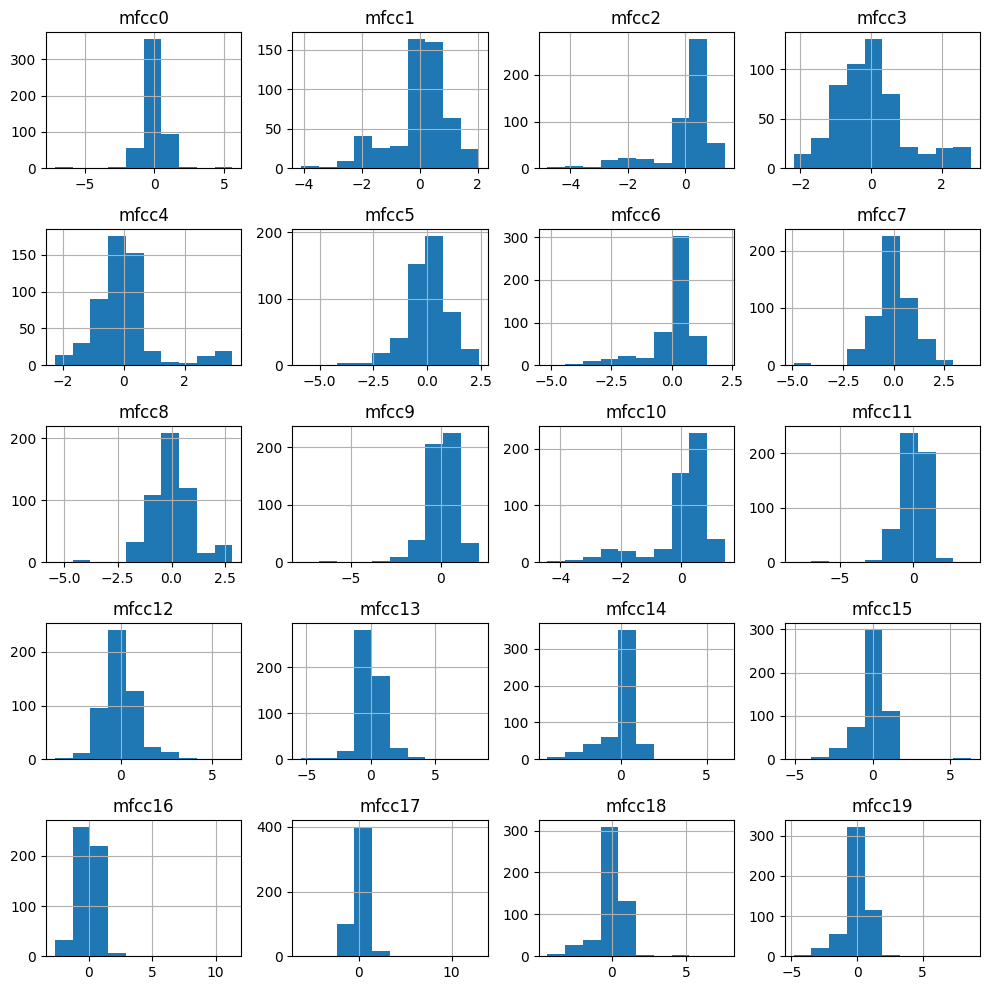

In [61]:
normalized_df.hist(figsize=(10, 10))
plt.tight_layout()

Maintenant toutes les variables prennent des valeurs entre -10 et 10, ce qui va aider à être moins sensibles aux échelles différentes des caractéristiques, améliorant ainsi la performance et la stabilité lors de l'entraînement.

On peut aussi vérifier qu'il n'y ait pas de valeurs dupliquées.

In [62]:
normalized_df.duplicated().sum()

0

#### Analyse des données

Nombre d'exemplaires dans chaque classe :
 artifact     40
murmur      129
normal      351
Name: label, dtype: int64

Fréquence de chaque classe:
 artifact     7.692308
murmur      24.807692
normal      67.500000
Name: label, dtype: float64


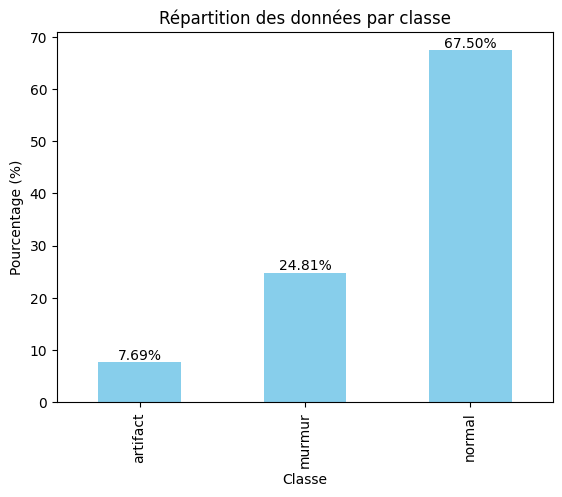

In [63]:
print("Nombre d'exemplaires dans chaque classe :\n", normalized_df['label'].value_counts().sort_index())

class_distribution = (normalized_df['label'].value_counts() / normalized_df['label'].count() * 100).sort_index()
print("\nFréquence de chaque classe:\n", class_distribution)

plt.figure()
class_distribution.plot.bar(color='skyblue')
plt.title("Répartition des données par classe")
plt.xlabel("Classe")
plt.ylabel("Pourcentage (%)")
for i, value in enumerate(class_distribution):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')
plt.show()

Dans notre cas, on dispose de beaucop d'exemplaires de "normal" (67.5%) et peu de "murmur" (25%) et très peu de "artifact" (7.5%). Les classes ne sont pas équilibrées, l'entraînement fonctionnera donc bien pour la classe "normal" mais potentiellement pas très bien pour les autres qui manquent de représentativité. On pourrait par exemple envisager de ne s'intéresser qu'à "normal" et "murmur" et donc écarter "artifact" de notre recherche (comme pour le setB).

#### Séparation des données en train-test

In [64]:
X_norm=normalized_df.iloc[:,0:20]
X_norm.head()


,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,-0.910022,-2.062391,0.243776,2.221529,2.692445,-0.060394,-0.069365,1.425402,1.958303,0.172944,-0.331606,0.766531,2.305124,0.929794,-0.558937,-0.645775,0.971809,0.740780,-0.262043,-0.538480
1,-0.036662,-0.373195,-2.120047,0.810744,0.750605,-1.020360,-1.266532,0.458976,1.115651,-1.107019,-1.641630,-1.333984,0.935124,-0.358970,-1.272885,-1.978391,-0.223199,-0.838935,-1.566999,-2.560117
2,-1.140562,-1.821174,-1.823289,1.654533,0.295038,-0.359384,-1.450319,1.544017,0.348821,0.289724,-1.476890,1.266705,0.614265,1.680041,-1.418465,0.038657,-0.159452,0.763204,-1.391138,-0.917421
3,-1.167339,-1.898498,0.407140,2.239135,2.537095,-0.313778,-0.192003,1.391169,1.987432,0.180610,-0.379789,0.571807,2.054639,0.585694,-0.732195,-0.872801,0.863390,0.705850,-0.254515,-0.539045
4,0.328214,-0.331521,-0.713491,0.950690,2.797089,0.769116,-0.205951,0.731691,1.619047,-0.051329,-1.068533,-1.042231,1.605590,1.563414,-0.762681,-2.216031,-0.251977,0.176554,-0.773302,-1.756697


In [65]:
from sklearn.preprocessing import LabelEncoder

# Encode le label de chaque classe par un chiffre
ylabel_norm=normalized_df["label"]
le_norm=LabelEncoder().fit(ylabel_norm)
y_norm=le_norm.transform(ylabel_norm)

print('Label',ylabel_norm[40],'correspond au numero',y_norm[40])
print('Label',ylabel_norm[0],'correspond au numero',y_norm[0])
print('Label',ylabel_norm[100],'correspond au numero',y_norm[100])


Label artifact correspond au numero 0
Label normal correspond au numero 2
Label murmur correspond au numero 1


In [66]:
# création de la base d'apprentissage et de test
from sklearn.model_selection import train_test_split

X_train_norm, X_test_norm , y_train_norm, y_test_norm =train_test_split(X_norm,y_norm,test_size=0.25,random_state=31,stratify=y) # stratify pour garder les mêmes proportions qu'au départ

print("Base d'apprentissage - X_Train_norm: ",len(X_train_norm),"\n","Base de test - X_Test_norm: ",len(X_test_norm),sep="")

# Description de l'ensemble d'apprentissage
values,count=np.unique(y_train_norm, return_counts=True)

print('label:',values,'nbre de valeurs:',count )

Base d'apprentissage - X_Train_norm: 390
Base de test - X_Test_norm: 130
label: [0 1 2] nbre de valeurs: [ 30  97 263]


In [67]:
# Conversion en matrice des bases d'apprentissage et test
X_train_norm = np.array(X_train_norm)
X_test_norm = np.array(X_test_norm)

# Toutes les données
X_all_norm = np.concatenate((X_train_norm, X_test_norm), axis=0)
y_all_norm = np.concatenate((y_train_norm, y_test_norm), axis=0)

# Liste des données par classe
liste_classe0 = np.ravel(np.where(y_train_norm==0))
liste_classe1 = np.ravel(np.where(y_train_norm==1))
liste_classe2 = np.ravel(np.where(y_train_norm==2))

### Méthodes d'apprentissage non supervisé

#### K-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

K-means sans normalisation

In [ ]:
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

In [ ]:
# Définir la plage des hyperparamètres à tester
n_clusters_options = [3] # Nous avons 3 classes donc 3 clusters
random_state_options = [0, 4, 8, 42]
n_init_options = [10, 15, 20, 25]

best_score = -1
best_params = {'n_clusters': None, 'random_state': None, 'n_init': None}

for n_clusters in n_clusters_options:
    for random_state in random_state_options:
        for n_init in n_init_options:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init).fit(X_all)
            score = silhouette_score(X_all, kmeans.labels_)

            if score > best_score:
                best_score = score
                best_params['n_clusters'] = n_clusters
                best_params['random_state'] = random_state
                best_params['n_init'] = n_init

print("Meilleurs paramètres:", best_params)


Meilleurs paramètres: {'n_clusters': 3, 'random_state': 4, 'n_init': 10}


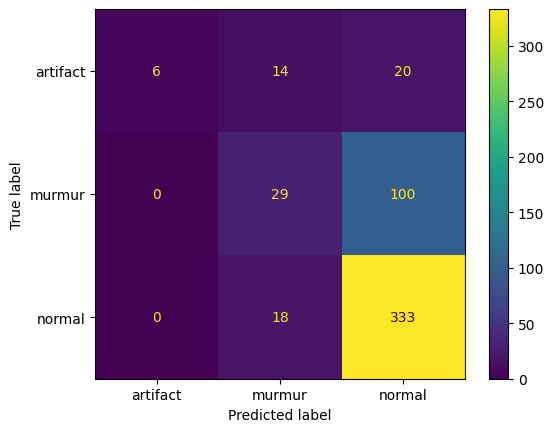

Accuracy : 0.7076923076923077


In [ ]:
# Appliquer K-means
kmeans = KMeans(n_clusters=3, random_state=4, n_init=10).fit_predict(X_all)

# Obtenir les étiquettes des clusters
labels_pred = correspondance(kmeans,y_all)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)

KMeans avec normalisation

In [ ]:
# Définir la plage des hyperparamètres à tester
n_clusters_options = [3] # Nous avons 3 classes donc 3 clusters
random_state_options = [0, 4, 8, 42]
n_init_options = [10, 15, 20, 25]

best_score = -1
best_params = {'n_clusters': None, 'random_state': None, 'n_init': None}

for n_clusters in n_clusters_options:
    for random_state in random_state_options:
        for n_init in n_init_options:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init).fit(X_all_norm)
            score = silhouette_score(X_all_norm, kmeans.labels_)

            if score > best_score:
                best_score = score
                best_params['n_clusters'] = n_clusters
                best_params['random_state'] = random_state
                best_params['n_init'] = n_init

print("Meilleurs paramètres:", best_params)


Meilleurs paramètres: {'n_clusters': 3, 'random_state': 8, 'n_init': 20}


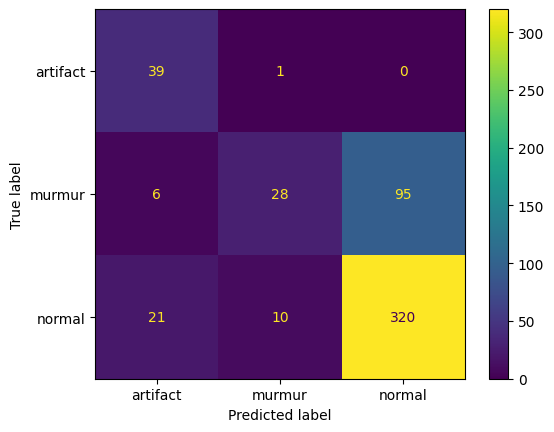

Accuracy : 0.7442307692307693


In [ ]:
# Appliquer K-means
kmeans = KMeans(n_clusters=3, random_state=8, n_init=20).fit_predict(X_all_norm)

# Obtenir les étiquettes des clusters
labels_pred = correspondance(kmeans,y_all)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)


KMeans avec ACP

In [ ]:
X_all_pca = np.concatenate((X_train_pca, X_test_pca), axis=0)

In [ ]:
# Définir la plage des hyperparamètres à tester
n_clusters_options = [3] # ici on veut 3 clusters puisqu'il y a 3 classes
random_state_options = [0, 4, 8, 42]
n_init_options = [10, 15, 20, 25]

best_score = -1
best_params = {'n_clusters': None, 'random_state': None, 'n_init': None}

for n_clusters in n_clusters_options:
    for random_state in random_state_options:
        for n_init in n_init_options:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init).fit(X_all_pca)
            score = silhouette_score(X_all_pca, kmeans.labels_)

            if score > best_score:
                best_score = score
                best_params['n_clusters'] = n_clusters
                best_params['random_state'] = random_state
                best_params['n_init'] = n_init

print("Meilleurs paramètres:", best_params)


Meilleurs paramètres: {'n_clusters': 3, 'random_state': 4, 'n_init': 10}


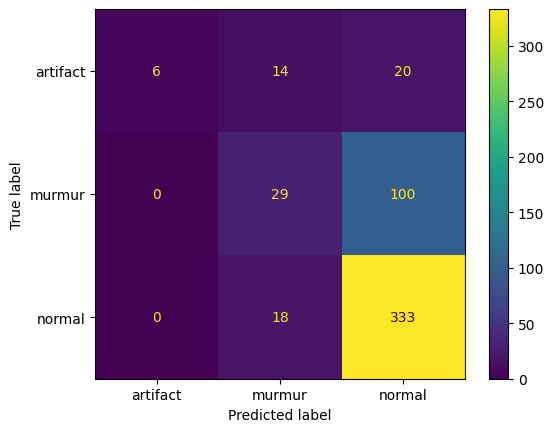

Accuracy : 0.7076923076923077


In [ ]:
# Appliquer K-means
kmeans = KMeans(n_clusters=3, random_state=4, n_init=10).fit_predict(X_all_pca)

# Obtenir les étiquettes des clusters
labels_pred = correspondance(kmeans,y_all)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)

#### DBScans

Sans normalisation ni ACP

In [68]:
from sklearn.cluster import DBSCAN

In [ ]:
# # Définir la plage des hyperparamètres à tester , plutôt à faire à la main ça ne marche pas vraiment
# n_eps_options = [i for i in range(10,60)]
# n_min_samples_options = [i for i in range(1,10)]

# best_score = -1
# best_params = {'eps': None, 'min_samples': None}

# for n_eps in n_eps_options:
#     for n_min_samples in n_min_samples_options:
#         dbscan = DBSCAN(eps=n_eps, min_samples=n_min_samples).fit(X_all)
#         score = silhouette_score(X_all, dbscan.labels_)

#         if score > best_score:
#             best_score = score
#             best_params['eps'] = n_eps
#             best_params['min_samples'] = n_min_samples

# print("Meilleurs paramètres:", best_params)

In [69]:
# modèle DBScans
dbscan = DBSCAN(eps=53, min_samples=2)
dbscan.fit(X_all)

# labels assignés par DBScans
labels = dbscan.labels_

# nb de clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters found:", n_clusters)


Number of clusters found: 9


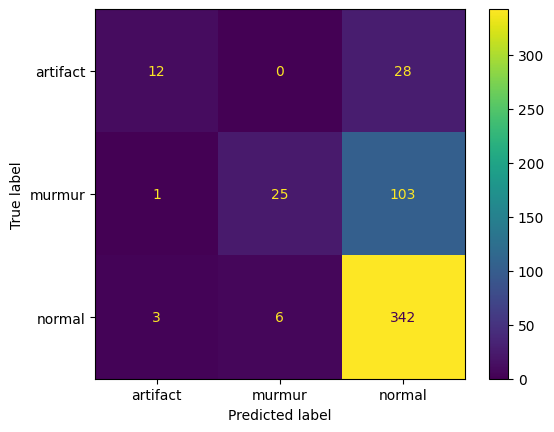

Accuracy : 0.7288461538461538


In [ ]:
# prédiction
labels_dbscans = dbscan.fit_predict(X_all)
labels_dbscans[labels_dbscans == -1] = 2 # les données trop bruitées sont probablement des artefacts, on remplace les erreurs dûes au bruit par le label artefact choisi par DBscans

# Obtenir les étiquettes des clusters
labels_pred = correspondance(labels_dbscans,y_all)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)



Avec normalisation

In [ ]:
# modèle DBScans
dbscan = DBSCAN(eps=2, min_samples=1)
dbscan.fit(X_all_norm)

# labels DBScans
labels = dbscan.labels_

# nb de clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters found:", n_clusters)

Number of clusters found: 64


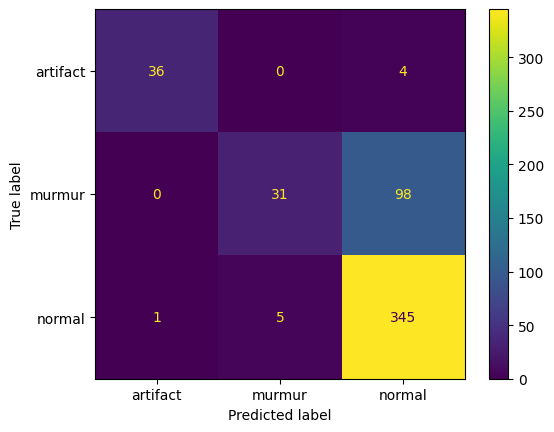

Accuracy : 0.7923076923076923


In [ ]:
# prédiction
labels_dbscans = dbscan.fit_predict(X_all_norm)
# labels_dbscans[labels_dbscans == -1] = 2 # pas nécessaire avec normalisation


# Obtenir les étiquettes des clusters
labels_pred = correspondance(labels_dbscans,y_all_norm)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all_norm, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all_norm, labels_pred)
print("Accuracy :", accuracy)



Avec ACP

In [ ]:
# modèle DBScans
dbscan = DBSCAN(eps=53, min_samples=2)
dbscan.fit(X_all_pca)

# labels DBScans
labels = dbscan.labels_

# nb clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters found:", n_clusters)

Number of clusters found: 9


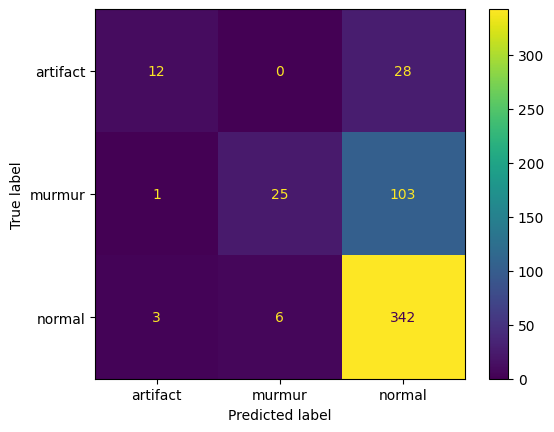

Accuracy : 0.7288461538461538


In [ ]:
# prédiction
labels_dbscans = dbscan.fit_predict(X_all_pca)
labels_dbscans[labels_dbscans == -1] = 2 # les données trop bruitées sont probablement des artefacts, on remplace les erreurs dûes au bruit par le label artefact choisi par DBscans

# Obtenir les étiquettes des clusters
labels_pred = correspondance(labels_dbscans,y_all)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)



#### Classification hiérarchique

In [ ]:
def retrieve_info_cluster(cluster_labels, y_train):
    reference_labels = {}

    # Boucle pour chaque label unique dans cluster_labels
    for i in np.unique(cluster_labels):
        index = np.where(cluster_labels == i)[0]
        if len(index) == 0:
            continue

        # Obtenir les labels correspondants dans y_train
        labels = y_train[index]

        # Vérifier si labels n'est pas vide
        if len(labels) == 0:
            continue

        # Trouver le label le plus fréquent
        num = np.bincount(labels).argmax()
        reference_labels[i] = num

    return reference_labels

def correspondance_cluster(cluster_labels, y_train):
    reference_labels = retrieve_info_cluster(cluster_labels, y_train)
    number_labels = np.zeros(len(cluster_labels))
    for i in range(len(cluster_labels)):
        number_labels[i] = reference_labels.get(cluster_labels[i], np.nan)  # Retourne NaN si aucun label n'est trouvé

    return number_labels


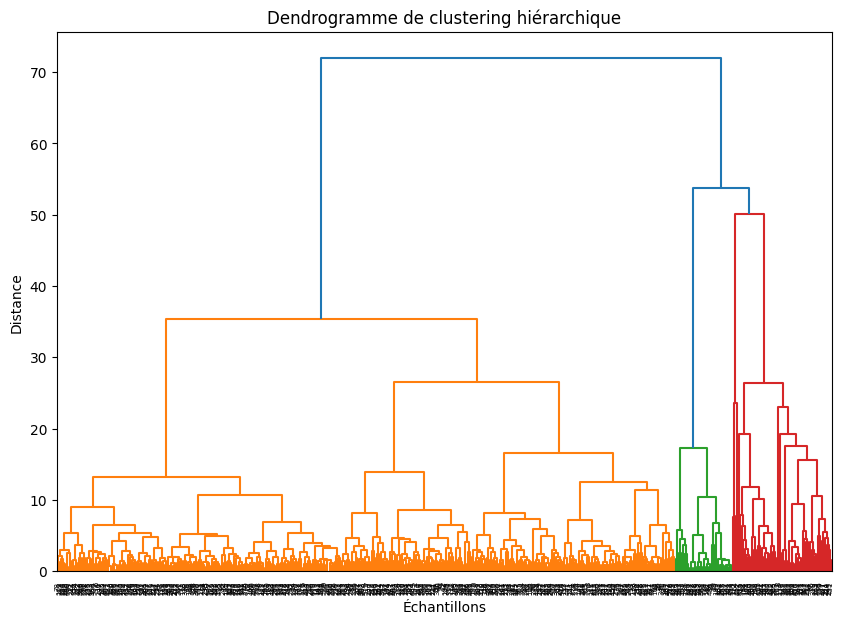

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Utiliser la méthode 'ward' pour le linkage, qui minimise la variance des clusters fusionnés
Z = linkage(X_all_norm, method='ward')

# Afficher le dendrogramme
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogramme de clustering hiérarchique")
plt.xlabel("Échantillons")
plt.ylabel("Distance")
plt.show()

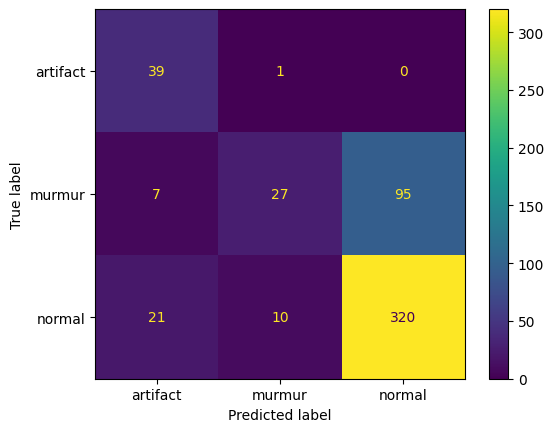

Accuracy : 0.7423076923076923


In [ ]:
# Former les clusters en coupant le dendrogramme à une certaine distance
distance_coupure = 51  # choisi en fonction du graphe au-dessus, correspond à la distance donnant 3 classes
cluster_labels = fcluster(Z, distance_coupure, criterion='distance')
# print(len(np.unique(cluster_labels))) # donne le nombre de classes
cluster_labels[cluster_labels == 3] = 0 # la classification hiérarchique ne donne pas de 0, on remplace les 3 par des 0 pour utiliser correspondance()
# Utiliser les fonctions déjà définies
labels_pred = correspondance(cluster_labels, y_all_norm)
labels = ["artifact","murmur","normal"]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_all, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= labels)
disp.plot()
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(y_all, labels_pred)
print("Accuracy :", accuracy)

### Méthode d'apprentissage supervisé

#### Forêt aléatoire, avec normalisation

Matrice de confusion :
[[10  0  0]
 [ 0 16 16]
 [ 2  1 85]]
Accuracy : 0.8538461538461538


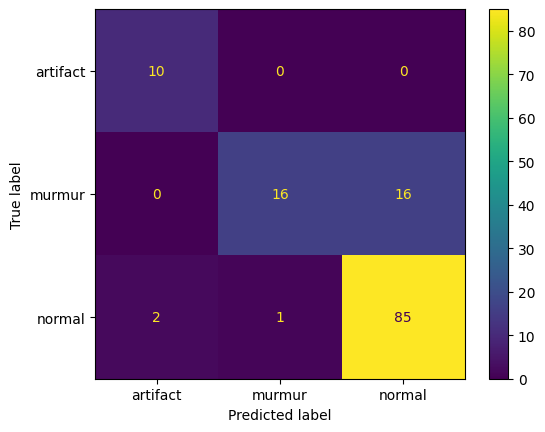

In [ ]:
# Modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train_norm, y_train_norm)

# Prédiction sur la base de test
y_pred_norm = rf.predict(X_test_norm)

# Calcul de la matrice de confusion
mat = confusion_matrix(y_test_norm, y_pred_norm)
print("Matrice de confusion :")
print(mat)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["artifact", "murmur", "normal"])
disp.plot()

# Calcul de l'accuracy
accuracy = rf.score(X_test_norm, y_test_norm)
print("Accuracy :", accuracy)